In [15]:
import os
import glob
import random
import cv2 as cv
import numpy as np
import timm
import torch
import torch.nn as nn
import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from sklearn.cluster import AgglomerativeClustering, BisectingKMeans, DBSCAN, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import fowlkes_mallows_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader

# Feature Extraction

In [ ]:
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

In [ ]:
def get_image(annot):
    img_path = "../images/"
    file = annot.split('\\')
    img_filename = img_path + file[-2] + "/" + file[-1] + ".jpg"
    return img_filename

In [ ]:
def image_resizing(dog_images, annotations):
    for i in range(len(dog_images)):
        bbox = get_bounding_boxes(annotations[i])
        dog = get_image(annotations[i])
        image = Image.open(dog)
        for j in range(len(bbox)):
            image_2 = image.crop(bbox[j])
            image_2 = image_2.resize((224,224), Image.Resampling.LANCZOS)
            new_path = dog.replace('../images/','../Resized/')
            new_path = new_path.replace('.jpg','-' + str(j) + '.jpg')
            image_2 = image_2.convert('RGB')
            head, tail = os.path.split(new_path)
            Path(head).mkdir(parents=True, exist_ok=True)
            image_2.save(new_path)

In [ ]:
dog_images = glob.glob("../images/*/*")
annotations = glob.glob("../annotations/*/*")
image_resizing(dog_images, annotations)

In [72]:
def get_images():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
#     folders = ["n02087394-Rhodesian_ridgeback", "n02102318-cocker_spaniel", "n02093256-Staffordshire_bullterrier", 
#                "n02097209-standard_schnauzer"]
    no_of_images = []
    for folder in folders:
        files = [f for f in os.listdir(f"../Resized/{folder}") if os.path.isfile(os.path.join(f"../Resized/{folder}", f))]
        no_of_images.append(len(files))
    
    no_of_images = np.array(no_of_images)
    
    collection = {}
    for folder, count in zip(folders, no_of_images):
        all_files = os.listdir(f"../Resized/{folder}")
        collection[folder] = all_files     
    
    return collection, folders, no_of_images

In [73]:
collection, folders, no_of_images = get_images()

In [74]:
def get_pixels():
    collection, folders, no_of_images = get_images()

    pixels = {}
    for folder, images in collection.items():
        combine = []
        for img in images:
            path = f"../Resized/{folder}/{img}"
            loaded_image = cv.imread(path)
            combine.append(loaded_image)
        combine = np.array(combine)
        pixels[folder] = combine
    
    return pixels, folders, no_of_images

In [75]:
pixels, folders, no_of_images = get_pixels() 
size = sum(no_of_images.tolist())

In [76]:
class_1_images = pixels[folders[0]]
class_2_images = pixels[folders[1]]
class_3_images = pixels[folders[2]]
class_4_images = pixels[folders[3]]

class_1_label = np.full(no_of_images[0], 0)  
class_2_label = np.full(no_of_images[1], 1)  
class_3_label = np.full(no_of_images[2], 2)  
class_4_label = np.full(no_of_images[3], 3)  

In [77]:
def normalized_dataset():   
    class_data = np.concatenate((class_1_images, class_2_images, class_3_images, class_4_images), axis=0)
    class_images = class_data.reshape((size, -1))
    
    scaler = StandardScaler()
    class_images = scaler.fit_transform(class_images)

    return class_images

In [78]:
class_data = normalized_dataset()

In [79]:
device = torch.device("cpu")
model = timm.create_model(model_name = 'resnet18', pretrained = True)
model.fc = nn.Linear(512, 4)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [80]:
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [81]:
model.global_pool.register_forward_hook(get_features('feats'))

In [82]:
data_loader = DataLoader(class_data, batch_size = size, shuffle = False)

In [83]:
PREDS = []
FEATS = []

features = {}

batch_size = size
channels = 3
height = 224
width = 224   

for i, inputs in enumerate(data_loader):
    inputs = inputs.view(batch_size, channels, height, width)
    inputs = inputs.to(device)
    preds = model(inputs.float())
    PREDS.append(preds.detach().cpu().numpy())
    FEATS.append(features['feats'].cpu().numpy())
    
#     if i == 9:
#         break

In [84]:
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)

print('- preds shape:', PREDS.shape)
print('- feats shape:', FEATS.shape)

- preds shape: (651, 4)
- feats shape: (651, 512)


In [85]:
def dimensionality_reduction():    
    pca = PCA(n_components = 2) 
    transformed_data = pca.fit_transform(FEATS)
    
    len_1 = len(class_1_images)
    len_2 = len(class_1_images) + len(class_2_images) 
    len_3 = len(class_1_images) + len(class_2_images) + len(class_3_images) 
        
    transformed_data_1 = transformed_data[:len_1]
    transformed_data_2 = transformed_data[len_1:len_2]
    transformed_data_3 = transformed_data[len_2:len_3]
    transformed_data_4 = transformed_data[len_3:]
    
    plt.scatter(transformed_data_1[:, 0], transformed_data_1[:, 1], color='r')
    plt.scatter(transformed_data_2[:, 0], transformed_data_2[:, 1], color='b')
    plt.scatter(transformed_data_3[:, 0], transformed_data_3[:, 1], color='y')
    plt.scatter(transformed_data_4[:, 0], transformed_data_4[:, 1], color='g')
    plt.show()
    
    return transformed_data

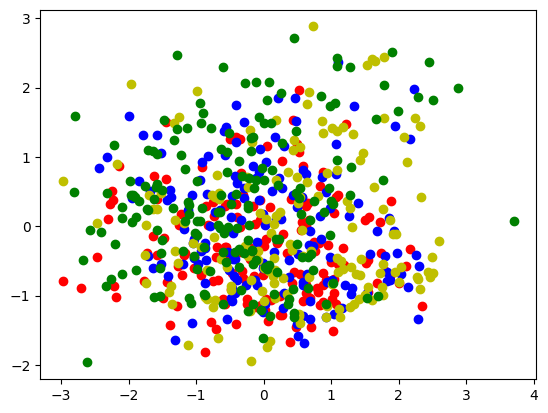

In [86]:
X = dimensionality_reduction()

^^^THIS PART IS A LOAD OF SHIIIITTT^^^

1. dimension reductions
2. all the clusters
3. all the evaluations

# Clustering Algorithms

In [ ]:
def k_means_clustering(X):
    kmeans = KMeans(n_clusters=4, random_state=0, init="random", n_init="auto").fit(X)
    
    return kmeans

In [ ]:
def k_means_plus(X):
    kmeans_plus = KMeans(n_clusters=4, random_state=0, init="k-means++", n_init="auto").fit(X)
    
    return kmeans_plus

In [ ]:
def bisecting_kmeans(X):
    b_kmeans = BisectingKMeans(n_clusters=4, random_state=0, init="random").fit(X)
    
    return b_kmeans

In [ ]:
def spectral_clustering(X):
    s_clustering = SpectralClustering(n_clusters=4).fit(X)
    
    return s_clustering

In [ ]:
def dbscan(X):
    dbscan_clustering = DBSCAN(eps=2.7, min_samples=10).fit(X)
    labels = dbscan_clustering.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(n_clusters)
    
    return dbscan_clustering

In [ ]:
def agglomerative_clustering(X):
    single = AgglomerativeClustering(n_clusters=4, linkage="single").fit(X)
    complete = AgglomerativeClustering(n_clusters=4, linkage="complete").fit(X)
    average = AgglomerativeClustering(n_clusters=4, linkage="average").fit(X)
    ward = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(X)
    
    return single, complete, average, ward

In [ ]:
kmeans = k_means_clustering(X)
kmeans_plus = k_means_plus(X)
b_kmeans = bisecting_kmeans(X)
s_clustering = spectral_clustering(X)
dbscan_clustering = dbscan(X)
single_clu, complete_clu, average_clu, ward_clu = agglomerative_clustering(X)
print(dbscan_clustering)

In [ ]:
def plot_clusters():
    plt.scatter(X[:, 0], X[:, 1], s=10, c=kmeans.labels_)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=20, c="r")
    plt.title("KMeans")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=kmeans_plus.labels_)
    plt.scatter(kmeans_plus.cluster_centers_[:, 0], kmeans_plus.cluster_centers_[:, 1], s=20, c="r")
    plt.title("KMeans++")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=b_kmeans.labels_)
    plt.scatter(b_kmeans.cluster_centers_[:, 0], b_kmeans.cluster_centers_[:, 1], s=20, c="r")
    plt.title("BisectingKMeans")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=s_clustering.labels_)
    plt.title("SpectralClustering")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=dbscan_clustering.labels_)
    plt.title("DBSCAN")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], c=single_clu.labels_)
    plt.title("Single Agglomerative Linkage")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], c=complete_clu.labels_)
    plt.title("Complete Agglomerative Linkage")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], c=average_clu.labels_)
    plt.title("Average Agglomerative Linkage")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], c=ward_clu.labels_)
    plt.title("Ward Agglomerative Linkage")
    plt.show()

In [ ]:
plot_clusters()

# Clustering Evalutions

In [ ]:
def fowlkes_mallows_score_evaluation():
    results = []
    labels_true = []
    labels_true.extend(class_1_label)
    labels_true.extend(class_2_label)
    labels_true.extend(class_3_label)
    labels_true.extend(class_4_label)
    
    clusters = [kmeans, kmeans_plus, b_kmeans, s_clustering, dbscan_clustering, 
                single_clu, complete_clu, average_clu, ward_clu]
    
    for method in clusters:
        results.append(fowlkes_mallows_score(labels_true, method.labels_))

    print(results)
    print(f"{clusters[results.index(max(results))]}: {max(results)}") 

In [ ]:
fowlkes_mallows_score_evaluation()

In [ ]:
def silhouette_score_evaluation():
    results = []
    clusters = [kmeans, kmeans_plus, b_kmeans, s_clustering, dbscan_clustering, 
                single_clu, complete_clu, average_clu, ward_clu]
    
    for method in clusters:
        results.append(silhouette_score(X, method.labels_))
        
    print(results)
    print(f"{clusters[results.index(max(results))]}: {max(results)}") 

In [ ]:
silhouette_score_evaluation()

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import timm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2
import os

device = torch.device('cuda')

In [ ]:
class ImageData(Dataset):
    
    # init
    def __init__(self, 
                 data, 
                 directory, 
                 transform):
        self.data      = data
        self.directory = directory
        self.transform = transform
        
    # length
    def __len__(self):
        return len(self.data)
    
    # get item  
    def __getitem__(self, idx):
        
        # import
        image = cv2.imread(os.path.join(self.directory, self.data.iloc[idx]['image_id']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        # augmentations
        image = self.transform(image = image)['image']
        
        return image

In [ ]:
# df = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
# display(df.head())

# augmentations
transforms = A.Compose([A.Resize(height = 128, width = 128),
                        A.Normalize(),
                        ToTensorV2()])
print(A.Normalize())
# dataset
# data_set = ImageData(data      = df, 
#                      directory = '../input/cassava-leaf-disease-classification/train_images/',
#                      transform = transforms)

# # dataloader
# data_loader = DataLoader(data_set, 
#                          batch_size  = 32, 
#                          shuffle     = False, 
#                          num_workers = 2)

In [ ]:
model    = timm.create_model(model_name = 'resnet18', pretrained = True)
model.fc = nn.Linear(512, 2)
model.to(device)

In [ ]:
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [ ]:
model.global_pool.register_forward_hook(get_features('feats'))

In [ ]:
# placeholders
PREDS = []
FEATS = []

# placeholder for batch features
features = {}

# loop through batches
for idx, inputs in enumerate(data_loader):

    # move to device
    inputs = inputs.to(device)
    print(inputs)
    # forward pass [with feature extraction]
    preds = model(inputs)
    
    # add feats and preds to lists
    PREDS.append(preds.detach().cpu().numpy())
    FEATS.append(features['feats'].cpu().numpy())

    # early stop
    if idx == 9:
        break